In [1]:
from problem_formulation import get_model_for_problem_formulation

import pickle

model, _ = get_model_for_problem_formulation(3)

In [2]:
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

#We do not understand yet why we need a reference_value, this is from the std document of dike_model_simulation.py

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 3.5, 'discount rate 1': 3.5,
                    'discount rate 2': 3.5,
                    'ID flood wave shape': 4}
scen1 = {}
#comparing scenario's with the refference to select scenario's fitted for the problem
for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
from ema_workbench import Scenario

ref_scenario = Scenario('reference', **scen1)

In [ ]:
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

from ema_workbench.em_framework.evaluators import BaseEvaluator

#The model is saving the convergence table every 500 nfr, so chose a large nomber to analhyse trends. 

nfe = 1500

#The amount of values for the epsilon list is dependend on the amount of outputs. How larger you choose your epsilon, 
#the more results you will get, you could chose a lower epsilon in this case. 

epsilon = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helping findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0,0,0,0,0,0,0,0,0,0,0,0], maximum=[1.1, 1.1, 1.1, 1.1, 1.1, 1.1 ,1.1 ,1.1 ,1.1 ,1.1 , 1.1, 1.1]),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle1 = False
if use_pickle1:
    with open('data/MORDM_results1.pickle','rb') as filehandler:
        results, convergence = pickle.load(filehandler)
        print(results)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario)
    #Save results in Pickle file
    with open("data/MORDM_results1.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

In [4]:
outcomes = results.loc[:, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
                           'A.2_Expected Number of Deaths','A.3 Total Costs','A.3_Expected Number of Deaths',
                           'A.4 Total Costs','A.4_Expected Number of Deaths','A.5 Total Costs',
                           'A.5_Expected Number of Deaths','RfR Total Costs','Expected Evacuation Costs']]

C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


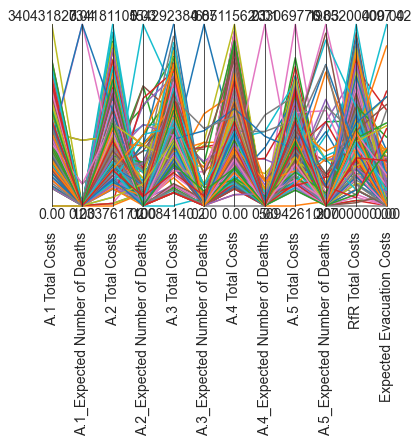

In [5]:
from ema_workbench.analysis import parcoords

#making a pairplot
import matplotlib.pyplot as plt

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

In [6]:
convergence
#as seen, the hypervolume stays 0, this indicates an error. 

hypervolume  epsilon_progress   nfe
0          0.0                 0     0
1          0.0                88   100
2          0.0               681  1197

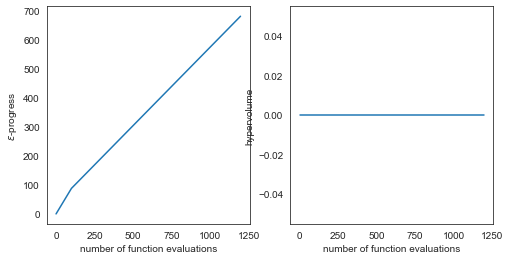

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()